# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Import 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import math
import timeit
import cv2
import os, sys
current_dir = os.getcwd()

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_pre, y_train_pre = train['features'], train['labels']
X_valid_pre, y_valid_pre = valid['features'], valid['labels']
X_test_pre, y_test_pre = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Step 1.1: Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train_pre)

# TODO: Number of validation examples
n_validation = len(X_valid_pre)

# TODO: Number of testing examples.
n_test = len(X_test_pre)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train_pre.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.max(y_train_pre) +1

print("Number of training examples =", n_train)
print("Number of Validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of Validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Step 1.2: Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

<function matplotlib.pyplot.show>

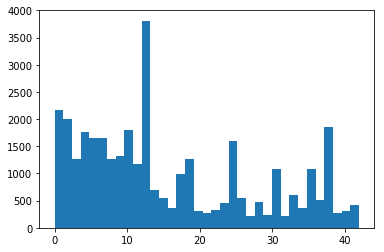

In [5]:
plt.hist(y_train_pre, bins='auto') 
plt.show

### Step 1.3: Image Augmentation

After trying different approaches, I ended up using only `transform()`

#### Augmentation Methods

In [6]:
from skimage import data, exposure, img_as_float
def gamma(images):
    gamma_random = 1 + np.random.uniform()*1
    return exposure.adjust_gamma(images, gamma_random) 

def brightness(images):
    images_cp = np.copy(images)
    for i, image in enumerate(images_cp):
        image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
        image = np.array(image, dtype = np.float64)
        random_bright = 0.5 + np.random.uniform()
        image[:,:,2] = image[:,:,2]*random_bright
        image[:,:,2][image[:,:,2]>255]  = 255
        image = np.array(image, dtype = np.uint8)
        image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
        images_cp[i] = image
    return images_cp

def gaussian_blur(images):
    images_cp = np.copy(images)
    for i, image in enumerate(images_cp):
        images_cp[i] = cv2.GaussianBlur(image, (3,3), 0)
    return images_cp

def random_noises(images):
    std = 5
    images_cp = np.copy(images)
    for i, image in enumerate(images_cp):
        image = image + np.random.randn(32,32,3) * std
        image[image>255]  = 255
        image[image<0]  = 0
        images_cp[i] = image
    return images_cp


def transform(images):
    ang_range = 12 #15
    shear_range = 0 #4
    trans_range = 0 #3
    Persp_range = 8 #1

    images_cp = np.copy(images)
    for i, image in enumerate(images_cp):
        # Rotation
        ang_rot = np.random.uniform(ang_range)-ang_range/2
        rows,cols,ch = image.shape    
        Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
        # Translation
        tr_x = trans_range*np.random.uniform()-trans_range/2
        tr_y = trans_range*np.random.uniform()-trans_range/2
        Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
        # Shear
        pts1 = np.float32([[5,5],[20,5],[5,20]])
        pt1 = 5+shear_range*np.random.uniform()-shear_range/2
        pt2 = 20+shear_range*np.random.uniform()-shear_range/2
        pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
        shear_M = cv2.getAffineTransform(pts1,pts2)
        
        # Perspecitve
        pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
        pts2 = np.float32(pts1 - np.ones([4,2])*0.5*Persp_range +  Persp_range * np.random.uniform(np.zeros([4,2])))
        Persp_M = cv2.getPerspectiveTransform(pts1,pts2)
            
        image = cv2.warpAffine(image,Rot_M,(cols,rows))
        image = cv2.warpAffine(image,Trans_M,(cols,rows))
        image = cv2.warpAffine(image,shear_M,(cols,rows))
        image = cv2.warpPerspective(image,Persp_M,(cols,rows))
        images_cp[i] = image
    return images_cp

def image_augmentation(images):
    images_aug = images
    images_aug = random_noises(images_aug)
    images_aug = transform(images_aug)

    return images_aug

In [7]:
def image_generator(X_train, y_train):
    num_pass = 7
    hist, _= np.histogram(y_train,bins=np.arange(44))
    mean_hist = len(y_train)//43
    idx_classes = np.where(hist <= mean_hist)[0]
    images_aug = np.array([], dtype = np.uint8).reshape(0,32,32,3)
    y_aug = np.array([], dtype = np.uint8)
    for idx_class in range(43):
        batch = X_train[y_train == idx_class]
        num_img = hist[idx_class]
        if num_img < mean_hist:
            num_aug = num_pass*mean_hist-num_img
#             num_aug = num_img*num_pass
        else: 
            num_aug = num_img*num_pass
        num_passes = num_aug//num_img
        
        for i in range(num_passes):
            images_aug = np.vstack((images_aug, image_augmentation(batch)))
        images_aug = np.vstack((images_aug, image_augmentation(batch[0:num_aug%num_img])))
        y_aug = np.append(y_aug, idx_class*np.ones((1,num_aug), dtype = np.uint8))
    return (np.vstack((X_train, images_aug)), np.append(y_train, y_aug))  

In [8]:
X_train_aug, y_train_aug= image_generator(X_train_pre, y_train_pre)

#### Histogram of augmented data

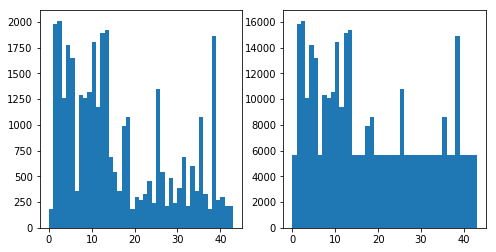

Pre-augmentation training size: 34799, Post-augmentation training size: 352678


In [9]:
plt.subplot(121)
plt.hist(y_train_pre, bins=np.arange(44)) 
plt.subplot(122)
plt.hist(y_train_aug, bins=np.arange(44)) 
plt.gcf().set_size_inches(8,4)
plt.show()
print('Pre-augmentation training size: {}, Post-augmentation training size: {}'.format(len(y_train_pre),len(y_train_aug)))

#### Plotting a random set of augmented images

In [10]:
def plot_class(imgs, label, class_num, num):
    num_img = np.sum(label == class_num)
    num_plot = np.minimum(num_img,num)
    idx_class = np.random.choice(np.where(label == class_num)[0],num_plot)
    print('class: {}, total plot count: {}'.format(class_num,num_plot))
    fig, axs = plt.subplots(int(np.ceil(num_plot / 6)), 6)
    i = 0
    for ax in axs.reshape(axs.size,-1):
        if i < num_plot:
            ax[0].imshow(imgs[idx_class[i]])
            ax[0].set_title('class='+str(class_num))
        i+= 1
    plt.gcf().set_size_inches(30, 5 * int(np.ceil(num_plot / 6)))
    plt.show()
    return axs

360
class: 16, total plot count: 12


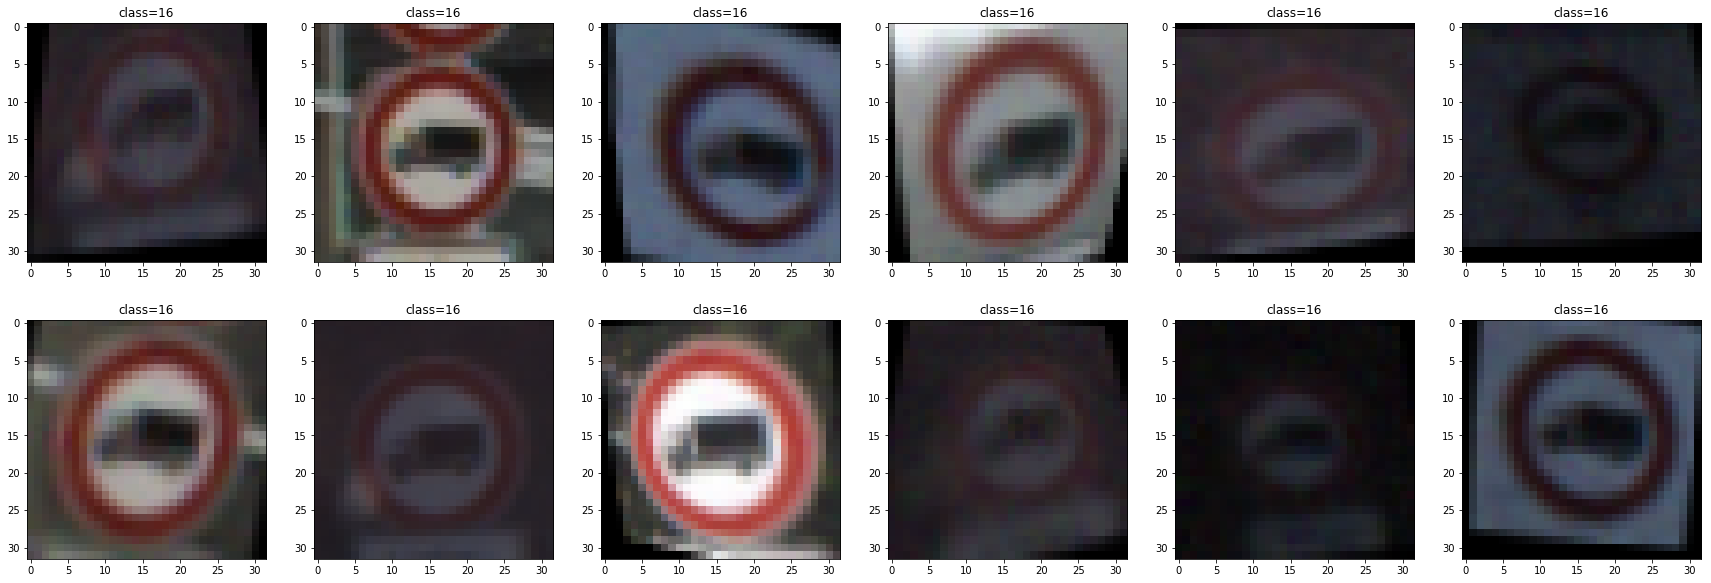

In [63]:
class_num = 16
print(np.sum(y_train_pre == class_num))
axs= plot_class(X_train_aug,y_train_aug,class_num = class_num,num = 12)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Step 2.1: Pre-process the Data Set (normalization, grayscale, etc.)

In this step, I apply the global normalization on the Y cahnnel of each image

In [12]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
def image_process(image):
    #gray_process
#     img = np.mean(image,3).reshape(-1,32,32,1)
    img = image
    return (img-128.0)/128.0 

def global_normal_Y(images):
    images_cp = np.zeros((images.shape[0],32,32,1))
    for i, image in enumerate(images):
        image = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
        image = np.array(image, dtype = np.float64)
        mean = np.mean(image[:,:,0])
        image[:,:,0] = image[:,:,0] - mean
        contrast =  np.sqrt(10.0 + np.mean(image[:,:,0] **2))
        image[:,:,0]  = 1.0  * image[:,:,0]  / max(contrast, 1e-6)
        images_cp[i] = image[:,:,0].reshape(32,32,1)
    return images_cp

#### Pre-processing and Shffling

In [13]:
X_train = global_normal_Y(X_train_aug)
y_train = y_train_aug

# from sklearn.utils import shuffle
# X_train, y_train = shuffle(X_train, y_train)

In [14]:
X_valid = global_normal_Y(X_valid_pre)
y_valid = y_valid_pre
X_test = global_normal_Y(X_test_pre)
y_test = y_test_pre

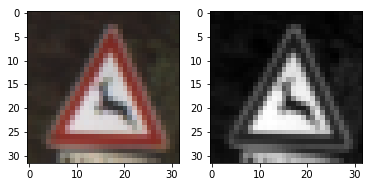

In [15]:
plt.subplot(121)
plt.imshow(X_train_pre[500])
plt.subplot(122)
plt.imshow(X_train[500].reshape([32,32]),cmap = 'gray')
plt.show()

In [16]:
def plot_class_gray(imgs, label, class_num, num):
    num_img = np.sum(label == class_num)
    num_plot = np.minimum(num_img,num)
    idx_class = np.random.choice(np.where(label == class_num)[0],num_plot)
    print('class: {}, total plot count: {}'.format(class_num,num_plot))
    fig, axs = plt.subplots(int(np.ceil(num_plot / 6)), 6)
    i = 0
    for ax in axs.reshape(axs.size,-1):
        if i < num_plot:
            ax[0].imshow(imgs[idx_class[i]],cmap = 'gray')
            ax[0].set_title('class='+str(class_num))
        i+= 1
        
    plt.gcf().set_size_inches(30, 5 * int(np.ceil(num_plot / 6)))
    plt.show()
    return axs

class: 8, total plot count: 12


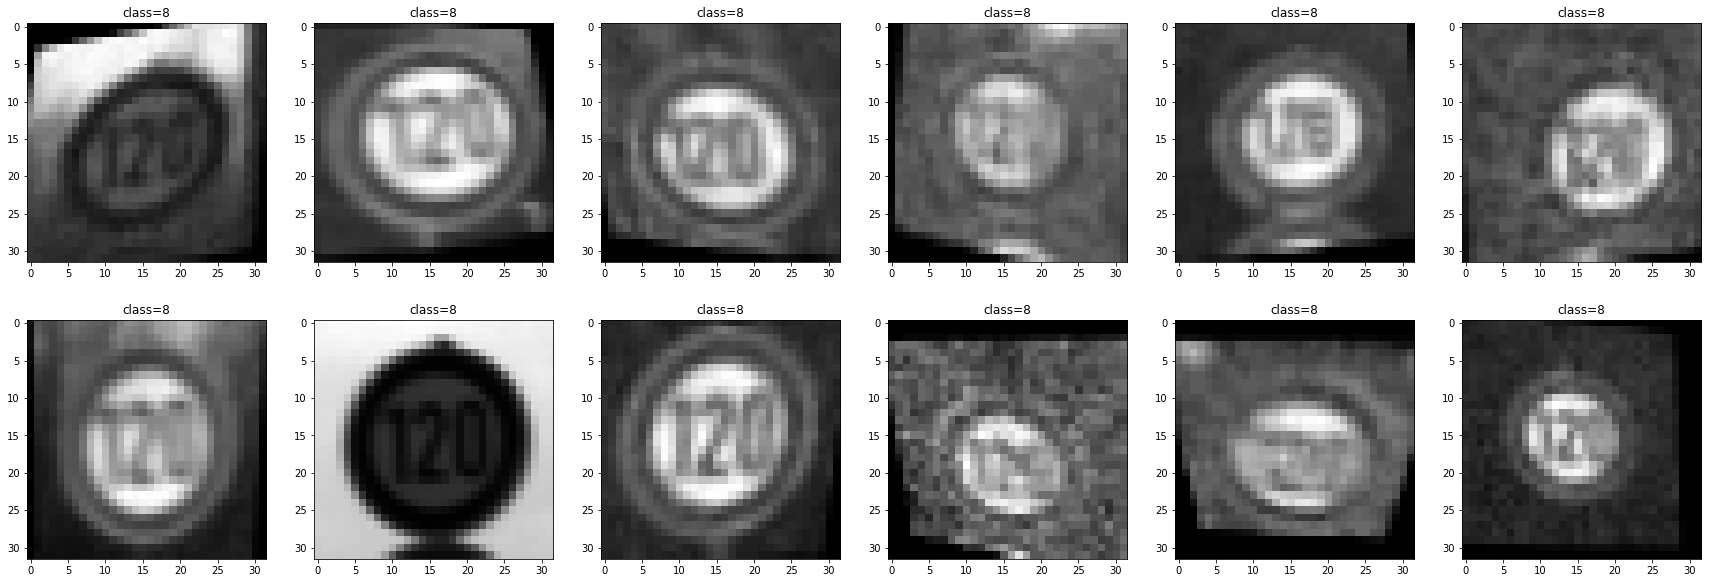

In [17]:
_ = plot_class_gray(X_train.reshape([-1,32,32]), y_train, 8, 12)

### Step 2.2: Model Architecture

####  Modifed LeNet with 3 CNN layers

In this section, we adopte a slightly more complicated model with the following structure:

* Conv Layer * 3
    * 3x3 Convolutional Layer with 64 filters and stride of 1
    * Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
    * ReLU Activation Layer
    * Maxpooling (first 2)
* Affine + Relu * 2
    * Affine layer
    * ReLU Activation Layer
* Affine 
    * Affine layer

In [18]:
def LeNet_v3(x,y,is_training):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Output = 30x30x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    L2 = tf.nn.l2_loss(conv1_W)
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.layers.batch_normalization(conv1, training = is_training)
    conv1_acti = tf.nn.relu(conv1)
    # Layer 1: Pooling. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1_acti, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 12x12x10.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 10), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(10))
    L2 += tf.nn.l2_loss(conv2_W)
    
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.layers.batch_normalization(conv2, training = is_training)
    conv2_acti = tf.nn.relu(conv2)

    # Layer 2: Pooling. Output = 6x6x10.
    conv2 = tf.nn.max_pool(conv2_acti, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    # Layer 3: Convolutional. Output = 4x4x16.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 10, 16), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(16))
    L2 += tf.nn.l2_loss(conv3_W)
    
    conv3 = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.layers.batch_normalization(conv3, training = is_training)
    conv3 = tf.nn.relu(conv3)

    # Flatten. Output = 256.
    fc0   = flatten(conv3)
    
    # Layer 1: Fully Connected. Input = 256. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(256, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    L2 += tf.nn.l2_loss(fc1_W)
    
    fc1  = tf.matmul(fc0, fc1_W) + fc1_b
    fc1  = tf.nn.relu(fc1)

    # Layer 2: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    L2 += tf.nn.l2_loss(fc2_W)
    
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)

    # Layer 3: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    L2 += tf.nn.l2_loss(fc3_W)
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
   
    return logits, L2, (conv1, conv1_acti,conv2,conv2_acti,conv3)

#### Chose the model and define loss function and optimizer

In [19]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 1])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# y_out = Model_v1(X,y,is_training)
y_out, L2, fmap = LeNet_v3(X,y,is_training)
save_name = 'LeNet_v3_4'

In [20]:
rate_t = tf.placeholder(tf.float32)
beta_t = tf.placeholder(tf.float32) #5e-4
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,43), logits=y_out)
mean_loss = tf.reduce_mean(cross_entropy) + beta_t * L2
optimizer = tf.train.AdamOptimizer(learning_rate = rate_t)

In [21]:
# have tensorflow compute accuracy
correct_prediction = tf.equal(tf.argmax(y_out,1), y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [22]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Step 2.3: Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

####  Train Model
This function is refernced to CS231n/Assignment2 

In [23]:
saver = tf.train.Saver()

def run_model(session, predict, loss_val, Xd, yd, lrn_rate = 1e-3, beta = 5e-4, epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, Xv = None, yv = None, valid_accuracy = 0):
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,predict]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    #loss_logger
    losses_log = []
    yout_log = np.zeros(yd.shape,dtype = np.int32)
    score_log = np.zeros([yd.shape[0], 43])
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []

        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now,
                         rate_t: lrn_rate,
                         beta_t: beta}
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, y_batch = session.run(variables, feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iter {0:>5}: with minibatch loss = {1:>4.3g} and minibatch accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            if not training_now:
                yout_log[idx] = np.argmax(y_batch,axis =1)
                score_log[idx] = y_batch
            iter_cnt += 1
            
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        losses_log.append(total_loss)
        #compute differential losses between epoches
        rel_loss = 1.0
        if e > 0: 
            rel_loss = (losses_log[e-1] - losses_log[e])/losses_log[e-1] 
        if rel_loss < 0.02:
            lrn_rate *= 0.5
        
        # Test with Validation set for every Epoch
        if Xv is not None and yv is not None:
            correct_valid = 0
            for i in range(int(math.ceil(Xv.shape[0]/batch_size))):
                # generate indicies for the batch
                valid_idx = (i*batch_size)%Xv.shape[0]

                # create a feed dictionary for this batch
                valid_dict = {X: Xv[valid_idx:valid_idx+batch_size,:],
                              y: yv[valid_idx:valid_idx+batch_size],
                              is_training: False }
                
                # get batch size
                valid_batch_size = yv[valid_idx:valid_idx+batch_size].shape[0]
                
                # have tensorflow compute loss and correct predictions
                # and (if given) perform a training step
                corr_valid = session.run(correct_prediction, feed_dict=valid_dict)
                correct_valid += np.sum(corr_valid)
            
            total_correct_valid = correct_valid/Xv.shape[0]
            print("Epoch {2}, Overall loss = {0:.3g}, test accuracy of {1:.3g} and valildation accuracy = {3:.3g}"\
              .format(total_loss,total_correct,e+1,total_correct_valid))
            
            if total_correct_valid > valid_accuracy:
                    valid_accuracy = total_correct_valid
                    saver.save(sess, current_dir+'/tmp/'+save_name)
                    print("Model saved for valid accuracy of {:.3g}".format(total_correct_valid))
        else:
            print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
#         if plot_losses:
#             plt.plot(losses)
#             plt.grid(True)
#             plt.title('Epoch {} Loss'.format(e+1))
#             plt.xlabel('minibatch number')
#             plt.ylabel('minibatch loss')
#             plt.show()
    return total_loss, total_correct, yout_log, valid_accuracy, score_log

#### Start traning and pick the model with the best validation accuracy

In [24]:
valid_accu = 0.97 # Fuse to prevent override 
for j in range(50):
    with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            print('Training...................pass = {} '.format(j+1))
            j +=1
            _,_,_,  valid_accu,_ = run_model(sess,y_out,mean_loss,X_train,y_train,lrn_rate = 5e-3, beta = 4e-4, \
                                           epochs = 30,batch_size = 240, print_every =1000000,training =train_step,\
                                           Xv = X_valid, yv = y_valid, valid_accuracy = valid_accu)
# size = 120, lrn_rate = 5e-3, beta = 5e-4
# use LeNet_v3_2 0.981

# size = 240, lrn_rate = 5e-3, beta = 3e-4
# use LeNet_v3_3 0.983

Training...................pass = 1 
Iter     0: with minibatch loss = 3.87 and minibatch accuracy of 0.017
Epoch 1, Overall loss = 0.572, test accuracy of 0.864 and valildation accuracy = 0.942
Epoch 2, Overall loss = 0.337, test accuracy of 0.94 and valildation accuracy = 0.944
Epoch 3, Overall loss = 0.315, test accuracy of 0.947 and valildation accuracy = 0.956
Epoch 4, Overall loss = 0.306, test accuracy of 0.951 and valildation accuracy = 0.952
Epoch 5, Overall loss = 0.298, test accuracy of 0.953 and valildation accuracy = 0.958
Epoch 6, Overall loss = 0.295, test accuracy of 0.954 and valildation accuracy = 0.951
Epoch 7, Overall loss = 0.218, test accuracy of 0.972 and valildation accuracy = 0.958
Epoch 8, Overall loss = 0.207, test accuracy of 0.971 and valildation accuracy = 0.962
Epoch 9, Overall loss = 0.201, test accuracy of 0.972 and valildation accuracy = 0.961
Epoch 10, Overall loss = 0.198, test accuracy of 0.971 and valildation accuracy = 0.959
Epoch 11, Overall loss

Epoch 29, Overall loss = 0.0769, test accuracy of 0.998 and valildation accuracy = 0.974
Epoch 30, Overall loss = 0.0757, test accuracy of 0.998 and valildation accuracy = 0.973
Training...................pass = 4 
Iter     0: with minibatch loss = 3.94 and minibatch accuracy of 0.037
Epoch 1, Overall loss = 0.565, test accuracy of 0.866 and valildation accuracy = 0.936
Epoch 2, Overall loss = 0.324, test accuracy of 0.943 and valildation accuracy = 0.938
Epoch 3, Overall loss = 0.304, test accuracy of 0.95 and valildation accuracy = 0.958
Epoch 4, Overall loss = 0.295, test accuracy of 0.953 and valildation accuracy = 0.928
Epoch 5, Overall loss = 0.289, test accuracy of 0.955 and valildation accuracy = 0.94
Epoch 6, Overall loss = 0.284, test accuracy of 0.956 and valildation accuracy = 0.965
Epoch 7, Overall loss = 0.211, test accuracy of 0.973 and valildation accuracy = 0.957
Epoch 8, Overall loss = 0.199, test accuracy of 0.973 and valildation accuracy = 0.965
Epoch 9, Overall los

Epoch 27, Overall loss = 0.0812, test accuracy of 0.997 and valildation accuracy = 0.974
Epoch 28, Overall loss = 0.079, test accuracy of 0.997 and valildation accuracy = 0.974
Epoch 29, Overall loss = 0.0782, test accuracy of 0.997 and valildation accuracy = 0.975
Epoch 30, Overall loss = 0.0771, test accuracy of 0.998 and valildation accuracy = 0.976
Training...................pass = 7 
Iter     0: with minibatch loss = 3.87 and minibatch accuracy of 0.029
Epoch 1, Overall loss = 0.562, test accuracy of 0.867 and valildation accuracy = 0.94
Epoch 2, Overall loss = 0.329, test accuracy of 0.941 and valildation accuracy = 0.953
Epoch 3, Overall loss = 0.304, test accuracy of 0.95 and valildation accuracy = 0.953
Epoch 4, Overall loss = 0.294, test accuracy of 0.953 and valildation accuracy = 0.966
Epoch 5, Overall loss = 0.286, test accuracy of 0.956 and valildation accuracy = 0.952
Epoch 6, Overall loss = 0.281, test accuracy of 0.957 and valildation accuracy = 0.962
Epoch 7, Overall 

Epoch 27, Overall loss = 0.0778, test accuracy of 0.997 and valildation accuracy = 0.969
Epoch 28, Overall loss = 0.077, test accuracy of 0.997 and valildation accuracy = 0.969
Epoch 29, Overall loss = 0.0758, test accuracy of 0.998 and valildation accuracy = 0.969
Epoch 30, Overall loss = 0.0751, test accuracy of 0.998 and valildation accuracy = 0.968
Training...................pass = 10 
Iter     0: with minibatch loss = 3.91 and minibatch accuracy of 0.017
Epoch 1, Overall loss = 0.602, test accuracy of 0.854 and valildation accuracy = 0.938
Epoch 2, Overall loss = 0.347, test accuracy of 0.936 and valildation accuracy = 0.935
Epoch 3, Overall loss = 0.321, test accuracy of 0.945 and valildation accuracy = 0.948
Epoch 4, Overall loss = 0.308, test accuracy of 0.949 and valildation accuracy = 0.96
Epoch 5, Overall loss = 0.301, test accuracy of 0.952 and valildation accuracy = 0.945
Epoch 6, Overall loss = 0.298, test accuracy of 0.952 and valildation accuracy = 0.949
Epoch 7, Overal

Epoch 27, Overall loss = 0.0812, test accuracy of 0.997 and valildation accuracy = 0.97
Epoch 28, Overall loss = 0.0805, test accuracy of 0.997 and valildation accuracy = 0.97
Epoch 29, Overall loss = 0.0793, test accuracy of 0.998 and valildation accuracy = 0.971
Epoch 30, Overall loss = 0.0786, test accuracy of 0.998 and valildation accuracy = 0.972
Training...................pass = 13 
Iter     0: with minibatch loss = 3.92 and minibatch accuracy of 0.013
Epoch 1, Overall loss = 0.611, test accuracy of 0.85 and valildation accuracy = 0.905
Epoch 2, Overall loss = 0.351, test accuracy of 0.934 and valildation accuracy = 0.949
Epoch 3, Overall loss = 0.323, test accuracy of 0.944 and valildation accuracy = 0.946
Epoch 4, Overall loss = 0.31, test accuracy of 0.949 and valildation accuracy = 0.946
Epoch 5, Overall loss = 0.3, test accuracy of 0.951 and valildation accuracy = 0.955
Epoch 6, Overall loss = 0.293, test accuracy of 0.954 and valildation accuracy = 0.956
Epoch 7, Overall lo

Epoch 27, Overall loss = 0.0833, test accuracy of 0.997 and valildation accuracy = 0.973
Epoch 28, Overall loss = 0.0811, test accuracy of 0.997 and valildation accuracy = 0.973
Epoch 29, Overall loss = 0.0803, test accuracy of 0.997 and valildation accuracy = 0.972
Epoch 30, Overall loss = 0.0791, test accuracy of 0.998 and valildation accuracy = 0.973
Training...................pass = 16 
Iter     0: with minibatch loss =  3.9 and minibatch accuracy of 0.013
Epoch 1, Overall loss = 0.59, test accuracy of 0.857 and valildation accuracy = 0.952
Epoch 2, Overall loss = 0.328, test accuracy of 0.941 and valildation accuracy = 0.946
Epoch 3, Overall loss = 0.305, test accuracy of 0.949 and valildation accuracy = 0.932
Epoch 4, Overall loss = 0.295, test accuracy of 0.953 and valildation accuracy = 0.946
Epoch 5, Overall loss = 0.287, test accuracy of 0.954 and valildation accuracy = 0.959
Epoch 6, Overall loss = 0.283, test accuracy of 0.956 and valildation accuracy = 0.953
Epoch 7, Overa

Epoch 27, Overall loss = 0.0797, test accuracy of 0.997 and valildation accuracy = 0.976
Epoch 28, Overall loss = 0.0782, test accuracy of 0.997 and valildation accuracy = 0.976
Epoch 29, Overall loss = 0.0761, test accuracy of 0.998 and valildation accuracy = 0.978
Epoch 30, Overall loss = 0.0753, test accuracy of 0.998 and valildation accuracy = 0.978
Training...................pass = 19 
Iter     0: with minibatch loss = 3.97 and minibatch accuracy of 0.013
Epoch 1, Overall loss = 0.572, test accuracy of 0.863 and valildation accuracy = 0.923
Epoch 2, Overall loss = 0.326, test accuracy of 0.941 and valildation accuracy = 0.939
Epoch 3, Overall loss = 0.304, test accuracy of 0.949 and valildation accuracy = 0.957
Epoch 4, Overall loss = 0.295, test accuracy of 0.952 and valildation accuracy = 0.934
Epoch 5, Overall loss = 0.286, test accuracy of 0.955 and valildation accuracy = 0.956
Epoch 6, Overall loss = 0.283, test accuracy of 0.956 and valildation accuracy = 0.943
Epoch 7, Over

Epoch 27, Overall loss = 0.0797, test accuracy of 0.997 and valildation accuracy = 0.976
Epoch 28, Overall loss = 0.0776, test accuracy of 0.997 and valildation accuracy = 0.976
Epoch 29, Overall loss = 0.0768, test accuracy of 0.998 and valildation accuracy = 0.976
Epoch 30, Overall loss = 0.0756, test accuracy of 0.998 and valildation accuracy = 0.976
Training...................pass = 22 
Iter     0: with minibatch loss = 3.88 and minibatch accuracy of 0.021
Epoch 1, Overall loss = 0.589, test accuracy of 0.859 and valildation accuracy = 0.927
Epoch 2, Overall loss = 0.337, test accuracy of 0.94 and valildation accuracy = 0.922
Epoch 3, Overall loss = 0.304, test accuracy of 0.95 and valildation accuracy = 0.926
Epoch 4, Overall loss = 0.289, test accuracy of 0.955 and valildation accuracy = 0.954
Epoch 5, Overall loss = 0.281, test accuracy of 0.957 and valildation accuracy = 0.955
Epoch 6, Overall loss = 0.275, test accuracy of 0.958 and valildation accuracy = 0.958
Epoch 7, Overal

Epoch 26, Overall loss = 0.0818, test accuracy of 0.997 and valildation accuracy = 0.972
Epoch 27, Overall loss = 0.081, test accuracy of 0.997 and valildation accuracy = 0.972
Epoch 28, Overall loss = 0.0798, test accuracy of 0.997 and valildation accuracy = 0.972
Epoch 29, Overall loss = 0.079, test accuracy of 0.998 and valildation accuracy = 0.972
Epoch 30, Overall loss = 0.0786, test accuracy of 0.998 and valildation accuracy = 0.972
Training...................pass = 25 
Iter     0: with minibatch loss = 3.87 and minibatch accuracy of 0.021
Epoch 1, Overall loss = 0.59, test accuracy of 0.857 and valildation accuracy = 0.934
Epoch 2, Overall loss = 0.336, test accuracy of 0.939 and valildation accuracy = 0.934
Epoch 3, Overall loss = 0.308, test accuracy of 0.949 and valildation accuracy = 0.941
Epoch 4, Overall loss = 0.296, test accuracy of 0.953 and valildation accuracy = 0.942
Epoch 5, Overall loss = 0.289, test accuracy of 0.955 and valildation accuracy = 0.943
Epoch 6, Overa

Epoch 26, Overall loss = 0.0796, test accuracy of 0.997 and valildation accuracy = 0.971
Epoch 27, Overall loss = 0.0789, test accuracy of 0.998 and valildation accuracy = 0.97
Epoch 28, Overall loss = 0.0777, test accuracy of 0.998 and valildation accuracy = 0.971
Epoch 29, Overall loss = 0.0769, test accuracy of 0.998 and valildation accuracy = 0.971
Epoch 30, Overall loss = 0.0765, test accuracy of 0.998 and valildation accuracy = 0.971
Training...................pass = 28 
Iter     0: with minibatch loss =  3.9 and minibatch accuracy of 0.021
Epoch 1, Overall loss = 0.569, test accuracy of 0.864 and valildation accuracy = 0.921
Epoch 2, Overall loss = 0.327, test accuracy of 0.942 and valildation accuracy = 0.927
Epoch 3, Overall loss = 0.305, test accuracy of 0.95 and valildation accuracy = 0.938
Epoch 4, Overall loss = 0.297, test accuracy of 0.952 and valildation accuracy = 0.953
Epoch 5, Overall loss = 0.29, test accuracy of 0.955 and valildation accuracy = 0.944
Epoch 6, Overa

Epoch 26, Overall loss = 0.0844, test accuracy of 0.996 and valildation accuracy = 0.969
Epoch 27, Overall loss = 0.0806, test accuracy of 0.997 and valildation accuracy = 0.971
Epoch 28, Overall loss = 0.0791, test accuracy of 0.997 and valildation accuracy = 0.972
Epoch 29, Overall loss = 0.077, test accuracy of 0.998 and valildation accuracy = 0.973
Epoch 30, Overall loss = 0.0762, test accuracy of 0.998 and valildation accuracy = 0.973
Training...................pass = 31 
Iter     0: with minibatch loss = 3.86 and minibatch accuracy of 0.013
Epoch 1, Overall loss = 0.581, test accuracy of 0.861 and valildation accuracy = 0.936
Epoch 2, Overall loss = 0.341, test accuracy of 0.937 and valildation accuracy = 0.957
Epoch 3, Overall loss = 0.316, test accuracy of 0.947 and valildation accuracy = 0.946
Epoch 4, Overall loss = 0.304, test accuracy of 0.95 and valildation accuracy = 0.948
Epoch 5, Overall loss = 0.295, test accuracy of 0.954 and valildation accuracy = 0.949
Epoch 6, Over

Epoch 26, Overall loss = 0.0825, test accuracy of 0.997 and valildation accuracy = 0.97
Epoch 27, Overall loss = 0.0802, test accuracy of 0.997 and valildation accuracy = 0.971
Epoch 28, Overall loss = 0.0794, test accuracy of 0.997 and valildation accuracy = 0.971
Epoch 29, Overall loss = 0.0782, test accuracy of 0.997 and valildation accuracy = 0.971
Epoch 30, Overall loss = 0.0775, test accuracy of 0.998 and valildation accuracy = 0.971
Training...................pass = 34 
Iter     0: with minibatch loss =  3.9 and minibatch accuracy of 0.017
Epoch 1, Overall loss = 0.564, test accuracy of 0.866 and valildation accuracy = 0.931
Epoch 2, Overall loss = 0.33, test accuracy of 0.941 and valildation accuracy = 0.959
Epoch 3, Overall loss = 0.31, test accuracy of 0.948 and valildation accuracy = 0.934
Epoch 4, Overall loss = 0.3, test accuracy of 0.952 and valildation accuracy = 0.956
Epoch 5, Overall loss = 0.291, test accuracy of 0.954 and valildation accuracy = 0.963
Epoch 6, Overall

Epoch 26, Overall loss = 0.0843, test accuracy of 0.997 and valildation accuracy = 0.977
Epoch 27, Overall loss = 0.0829, test accuracy of 0.997 and valildation accuracy = 0.977
Epoch 28, Overall loss = 0.0806, test accuracy of 0.997 and valildation accuracy = 0.976
Epoch 29, Overall loss = 0.0799, test accuracy of 0.998 and valildation accuracy = 0.976
Epoch 30, Overall loss = 0.0787, test accuracy of 0.998 and valildation accuracy = 0.975
Training...................pass = 37 
Iter     0: with minibatch loss = 3.89 and minibatch accuracy of 0.013
Epoch 1, Overall loss = 0.587, test accuracy of 0.858 and valildation accuracy = 0.946
Epoch 2, Overall loss = 0.334, test accuracy of 0.94 and valildation accuracy = 0.955
Epoch 3, Overall loss = 0.308, test accuracy of 0.948 and valildation accuracy = 0.951
Epoch 4, Overall loss = 0.297, test accuracy of 0.952 and valildation accuracy = 0.96
Epoch 5, Overall loss = 0.289, test accuracy of 0.955 and valildation accuracy = 0.959
Epoch 6, Over

Epoch 26, Overall loss = 0.087, test accuracy of 0.996 and valildation accuracy = 0.971
Epoch 27, Overall loss = 0.0852, test accuracy of 0.996 and valildation accuracy = 0.97
Epoch 28, Overall loss = 0.0813, test accuracy of 0.997 and valildation accuracy = 0.971
Epoch 29, Overall loss = 0.0798, test accuracy of 0.997 and valildation accuracy = 0.97
Epoch 30, Overall loss = 0.0777, test accuracy of 0.998 and valildation accuracy = 0.969
Training...................pass = 40 
Iter     0: with minibatch loss = 3.87 and minibatch accuracy of 0.042
Epoch 1, Overall loss = 0.576, test accuracy of 0.862 and valildation accuracy = 0.912
Epoch 2, Overall loss = 0.332, test accuracy of 0.94 and valildation accuracy = 0.944
Epoch 3, Overall loss = 0.307, test accuracy of 0.949 and valildation accuracy = 0.939
Epoch 4, Overall loss = 0.299, test accuracy of 0.952 and valildation accuracy = 0.949
Epoch 5, Overall loss = 0.29, test accuracy of 0.955 and valildation accuracy = 0.955
Epoch 6, Overall

Epoch 26, Overall loss = 0.0799, test accuracy of 0.997 and valildation accuracy = 0.971
Epoch 27, Overall loss = 0.0777, test accuracy of 0.997 and valildation accuracy = 0.972
Epoch 28, Overall loss = 0.0769, test accuracy of 0.998 and valildation accuracy = 0.971
Epoch 29, Overall loss = 0.0758, test accuracy of 0.998 and valildation accuracy = 0.972
Epoch 30, Overall loss = 0.0751, test accuracy of 0.998 and valildation accuracy = 0.972
Training...................pass = 43 
Iter     0: with minibatch loss =  3.9 and minibatch accuracy of 0.029
Epoch 1, Overall loss = 0.542, test accuracy of 0.872 and valildation accuracy = 0.919
Epoch 2, Overall loss = 0.32, test accuracy of 0.944 and valildation accuracy = 0.955
Epoch 3, Overall loss = 0.299, test accuracy of 0.951 and valildation accuracy = 0.944
Epoch 4, Overall loss = 0.29, test accuracy of 0.954 and valildation accuracy = 0.94
Epoch 5, Overall loss = 0.286, test accuracy of 0.956 and valildation accuracy = 0.933
Epoch 6, Overa

Epoch 26, Overall loss = 0.0794, test accuracy of 0.997 and valildation accuracy = 0.972
Epoch 27, Overall loss = 0.0773, test accuracy of 0.997 and valildation accuracy = 0.973
Epoch 28, Overall loss = 0.0766, test accuracy of 0.998 and valildation accuracy = 0.973
Epoch 29, Overall loss = 0.0754, test accuracy of 0.998 and valildation accuracy = 0.973
Epoch 30, Overall loss = 0.0747, test accuracy of 0.998 and valildation accuracy = 0.973
Training...................pass = 46 
Iter     0: with minibatch loss =  3.9 and minibatch accuracy of 0.017
Epoch 1, Overall loss = 0.575, test accuracy of 0.862 and valildation accuracy = 0.92
Epoch 2, Overall loss = 0.338, test accuracy of 0.938 and valildation accuracy = 0.95
Epoch 3, Overall loss = 0.315, test accuracy of 0.947 and valildation accuracy = 0.935
Epoch 4, Overall loss = 0.301, test accuracy of 0.951 and valildation accuracy = 0.963
Epoch 5, Overall loss = 0.293, test accuracy of 0.953 and valildation accuracy = 0.957
Epoch 6, Over

Epoch 26, Overall loss = 0.0891, test accuracy of 0.996 and valildation accuracy = 0.977
Epoch 27, Overall loss = 0.0867, test accuracy of 0.997 and valildation accuracy = 0.976
Epoch 28, Overall loss = 0.0858, test accuracy of 0.997 and valildation accuracy = 0.976
Epoch 29, Overall loss = 0.0846, test accuracy of 0.997 and valildation accuracy = 0.977
Epoch 30, Overall loss = 0.0838, test accuracy of 0.997 and valildation accuracy = 0.977
Training...................pass = 49 
Iter     0: with minibatch loss = 4.03 and minibatch accuracy of 0.046
Epoch 1, Overall loss = 0.558, test accuracy of 0.867 and valildation accuracy = 0.937
Epoch 2, Overall loss = 0.315, test accuracy of 0.944 and valildation accuracy = 0.953
Epoch 3, Overall loss = 0.295, test accuracy of 0.951 and valildation accuracy = 0.953
Epoch 4, Overall loss = 0.286, test accuracy of 0.954 and valildation accuracy = 0.953
Epoch 5, Overall loss = 0.281, test accuracy of 0.956 and valildation accuracy = 0.944
Epoch 6, Ov

#### Show images with incorrect predictions

In [28]:
with tf.Session() as sess:
    saver.restore(sess, current_dir+'/tmp/'+save_name)
    print('Validation Set Report')
    _, _, yout_valid,_,_ = run_model(sess,y_out,mean_loss,X_valid,y_valid,batch_size=64)

INFO:tensorflow:Restoring parameters from /home/gexd7127/git/Udacity/CarND-Traffic-Sign-Classifier-Project/tmp/LeNet_v3_4
Validation Set Report
Epoch 1, Overall loss = 0.186 and accuracy of 0.981


In [29]:
# Construct false images' index and top false classes
idx_false = np.not_equal(yout_valid,y_valid)
y_valid_false = y_valid_pre[idx_false]
X_valid_false = X_valid_pre[idx_false]
hist_valid, bins= np.histogram(y_valid,bins=np.arange(44))
hist_false, bins= np.histogram(y_valid_false,bins=np.arange(44))
topclasses_false = np.flip(np.argsort(hist_false),0)

#### Histogram of incorrect predicted images by classes

<function matplotlib.pyplot.show>

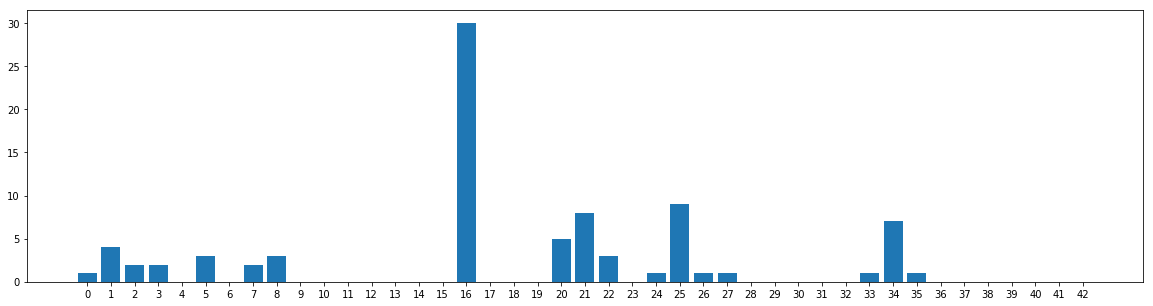

In [150]:
plt.bar(range(43),hist_false)
plt.xticks( range(43), range(43))
plt.gcf().set_size_inches(20, 5)
plt.rcParams.update({'font.size': 10})
plt.show

#### The most problmatic class

class: 16, total plot count: 12


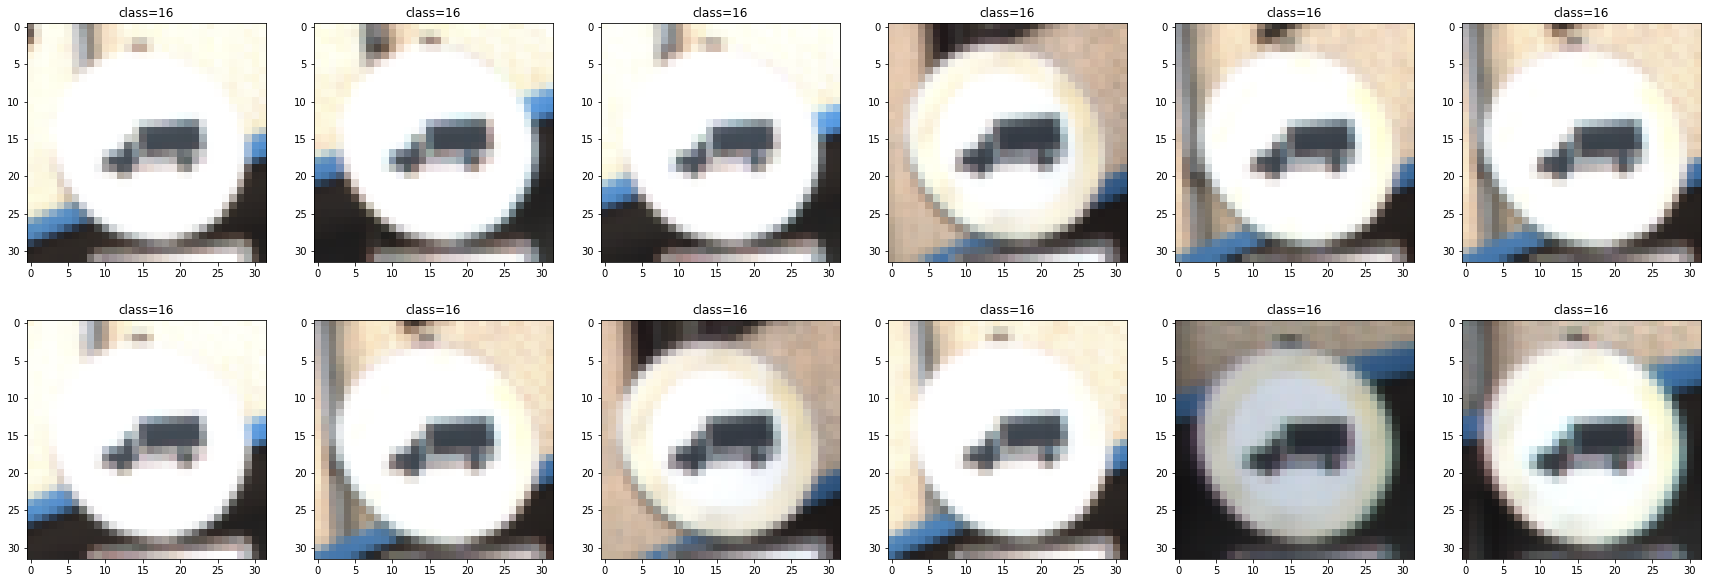

In [151]:
_ = plot_class(X_valid_false, y_valid_false, topclasses_false[0],12)

#### Reporting

In [32]:
with tf.Session() as sess:
    saver.restore(sess, current_dir+'/tmp/'+save_name)
    print('Training Set Report')
    _, _, yout_train,_,_ = run_model(sess,y_out,mean_loss,X_train,y_train,batch_size=64)

INFO:tensorflow:Restoring parameters from /home/gexd7127/git/Udacity/CarND-Traffic-Sign-Classifier-Project/tmp/LeNet_v3_4
Training Set Report
Epoch 1, Overall loss = 0.0919 and accuracy of 0.998


In [33]:
with tf.Session() as sess:
    saver.restore(sess, current_dir+'/tmp/'+save_name)
    print('Validation Set Report')
    _, _, yout_valid,_,_ = run_model(sess,y_out,mean_loss,X_valid,y_valid,batch_size=64)

INFO:tensorflow:Restoring parameters from /home/gexd7127/git/Udacity/CarND-Traffic-Sign-Classifier-Project/tmp/LeNet_v3_4
Validation Set Report
Epoch 1, Overall loss = 0.186 and accuracy of 0.981


In [34]:
with tf.Session() as sess:
    saver.restore(sess, current_dir+'/tmp/'+save_name)
    print('Test Set Report')
    _, _, yout_test,_,_ = run_model(sess,y_out,mean_loss,X_test,y_test,batch_size=64)

INFO:tensorflow:Restoring parameters from /home/gexd7127/git/Udacity/CarND-Traffic-Sign-Classifier-Project/tmp/LeNet_v3_4
Test Set Report
Epoch 1, Overall loss = 0.256 and accuracy of 0.96


### 2.4 Precision and Recall on Test set

In [190]:
precision = np.array([])
recall = np.array([])
for i in range(43):
    class_mask = y_test == i
    test_mask = yout_test == i
    true_positive = class_mask & test_mask
    precision = np.append(precision, np.sum(true_positive)/np.sum(test_mask))
    recall = np.append(recall, np.sum(true_positive)/np.sum(class_mask))

<function matplotlib.pyplot.show>

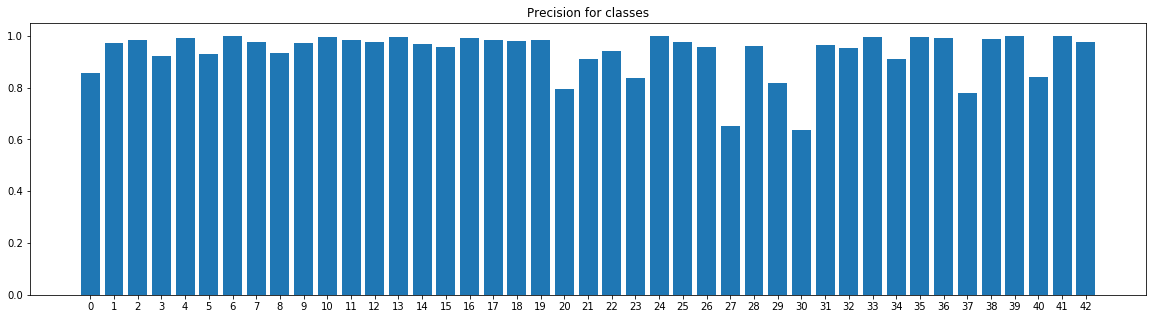

In [191]:
plt.bar(range(43),precision)
plt.title('Precision for classes')
plt.xticks( range(43), range(43))
plt.gcf().set_size_inches(20, 5)
plt.rcParams.update({'font.size': 10})
plt.show

<function matplotlib.pyplot.show>

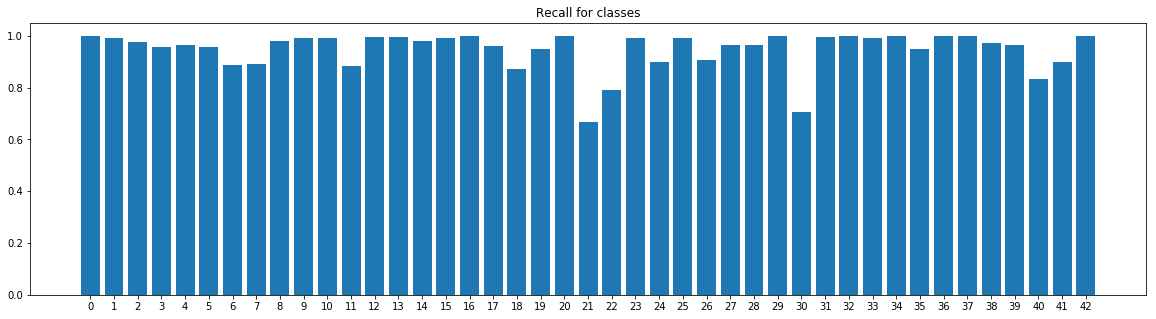

In [192]:
plt.bar(range(43),recall)
plt.title('Recall for classes')
plt.xticks( range(43), range(43))
plt.gcf().set_size_inches(20, 5)
plt.rcParams.update({'font.size': 10})
plt.show

#### Plot classes with low precision 

In [547]:
def plot_images(imgs, num):
    idx_class = np.random.choice(imgs.shape[0],num)
    print('class: {}, total plot count: {}'.format(class_num,num))
    fig, axs = plt.subplots(int(np.ceil(num / 6)), 6)
    i = 0
    for ax in axs.reshape(axs.size,-1):
        if i < num:
            ax[0].imshow(imgs[idx_class[i]])
            ax[0].set_title('class='+str(class_num))
        i+= 1
    plt.gcf().set_size_inches(30, 5 * int(np.ceil(num / 6)))
    plt.show()
    return axs

In [551]:
y_test_pre[yout_test == 30]

array([30, 30, 30, 11, 11, 30, 30, 18, 30, 11, 30, 11, 18, 11, 30, 11, 30,
       11, 30, 11, 11, 30, 30, 30, 30, 30, 30, 11, 30, 30, 30, 30, 18, 30,
       30, 30, 30, 24, 30, 30, 30, 18, 11, 30, 18, 11, 11, 30, 30, 11, 11,
       28, 11, 30, 30, 18, 30, 30, 30, 11, 11,  6, 30, 30, 11, 30, 30, 30,
       11, 30, 11, 30, 11, 30, 30, 30, 30, 18, 28, 30, 11, 30, 30, 11, 30,
       11, 30, 30, 30, 30, 11, 30, 30, 30, 28, 28, 11, 30, 30, 30, 30, 30,
       30, 30, 11, 30, 30, 30, 30, 11, 30, 30, 18, 30, 30, 30, 30, 30, 30,
       30, 30, 18, 11, 11, 11, 30, 30, 11, 30, 11, 18, 30, 30, 30, 11, 11,
       30, 11, 18, 30, 30, 11, 30, 30, 30, 30, 30, 11, 30, 30, 30, 11, 30,
       30, 18, 30, 30, 30, 30, 30, 28, 30, 30, 11, 30, 30, 11], dtype=uint8)

class: 16, total plot count: 12


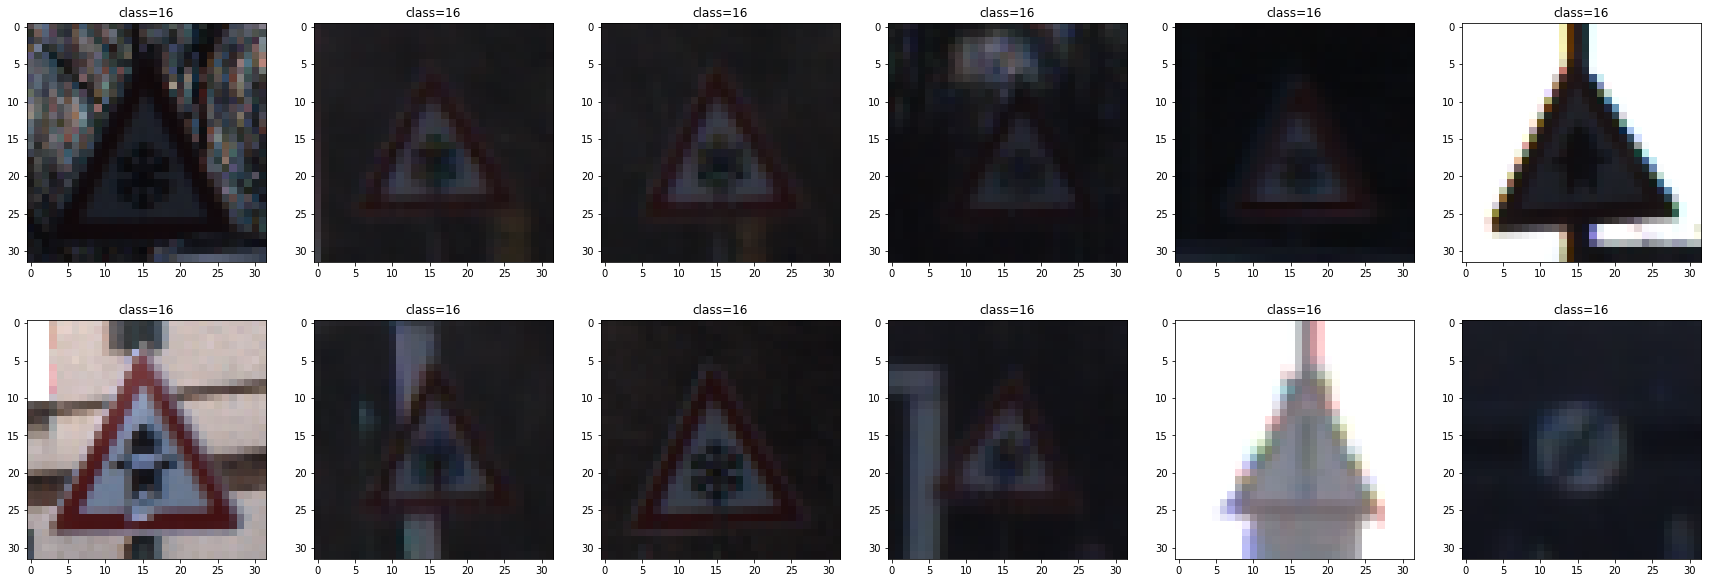

In [553]:
_ = plot_images(X_test_pre[yout_test == 30],12)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Step 3.1 Load and Output the Images

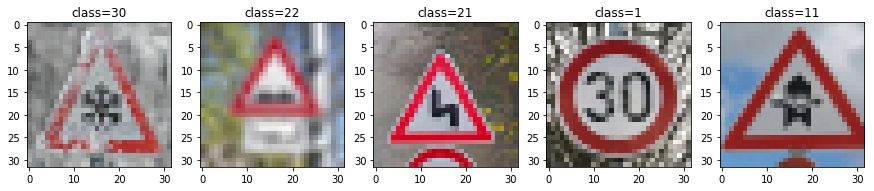

In [544]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
X_web_pre = np.array([], dtype = np.uint8).reshape(0,32,32,3)
y_web_pre = np.array([], dtype = np.uint8)
data_dir = 'data/test/'
i = 0
for filename in os.listdir(data_dir):
    num_files = len(os.listdir(data_dir))
    images = mpimg.imread(data_dir+filename)
    images = cv2.resize(images, (32,32)).reshape(1,32,32,3);
    X_web_pre = np.vstack((X_web_pre, images))
    y_web_pre = np.append(y_web_pre, np.uint8(filename[0:2]))
    plt.subplot(101 + 10*num_files + i)
    plt.imshow(images[0])
    plt.title('class='+str(np.uint8(filename[0:2])))
    i += 1
plt.gcf().set_size_inches(num_files*3, num_files*3)
plt.show()

### Step 3.2 Predict the Sign Type for Each Image

In [463]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [545]:
X_web = global_normal_Y(X_web_pre)
y_web = y_web_pre

with tf.Session() as sess:
    saver.restore(sess, current_dir+'/tmp/'+save_name)
    print('Web Testing..............')
    _, _, yout_web,_, score_web = run_model(sess,y_out,mean_loss,X_web,y_web,batch_size=64)

INFO:tensorflow:Restoring parameters from /home/gexd7127/git/Udacity/CarND-Traffic-Sign-Classifier-Project/tmp/LeNet_v3_4
Web Testing..............
Epoch 1, Overall loss = 3.29 and accuracy of 0.6


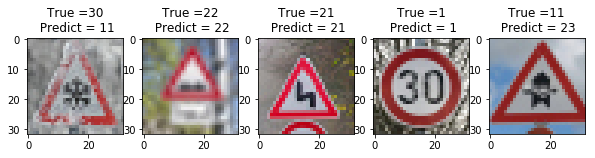

In [546]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
X_web_pre = np.array([], dtype = np.uint8).reshape(0,32,32,3)
y_web_pre = np.array([], dtype = np.uint8)
data_dir = 'data/test/'
i = 0
for filename in os.listdir(data_dir):
    num_files = len(os.listdir(data_dir))
    images = mpimg.imread(data_dir+filename)
    images = cv2.resize(images, (32,32)).reshape(1,32,32,3);
    X_web_pre = np.vstack((X_web_pre, images))
    y_web_pre = np.append(y_web_pre, np.uint8(filename[0:2]))
    plt.subplot(101 + 10*num_files + i)
    plt.imshow(images[0])
    plt.title('True ='+str(np.uint8(filename[0:2]))+'\n Predict = '+str(np.uint8(yout_web[i])))
    i += 1
plt.gcf().set_size_inches(num_files*2, num_files*2)
plt.show()

### Step 3.3 Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [554]:
web_accuracy = np.mean(np.equal(yout_web,y_web))
print('Accuracy of the web images = {}'.format(web_accuracy))

Accuracy of the web images = 0.6


### Step 3.4 Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In [575]:
score_pro = np.exp(score_web)/ np.sum(np.exp(score_web),1).reshape(5,1)

In [595]:
with tf.Session() as sess:
    Top5 = sess.run(tf.nn.top_k(tf.constant(score_pro), k=5))   
Top5    

TopKV2(values=array([[  9.99862420e-01,   4.50983233e-05,   3.88867145e-05,
          3.48677999e-05,   1.21836387e-05],
       [  9.99995510e-01,   4.01864797e-06,   4.58687360e-07,
          1.07360388e-08,   1.56105011e-09],
       [  9.72144378e-01,   2.78554700e-02,   1.37118686e-07,
          1.15664714e-08,   2.30518549e-09],
       [  9.98040386e-01,   1.49775377e-03,   4.55781292e-04,
          5.87581864e-06,   1.85444350e-07],
       [  9.97147200e-01,   2.76982539e-03,   7.78266365e-05,
          4.09955846e-06,   3.60816014e-07]]), indices=array([[11, 23, 30, 40, 25],
       [22, 23, 29,  9, 10],
       [21, 31, 19, 23, 25],
       [ 1,  0,  5,  2,  4],
       [23, 11, 30, 21, 29]], dtype=int32))

<function matplotlib.pyplot.show>

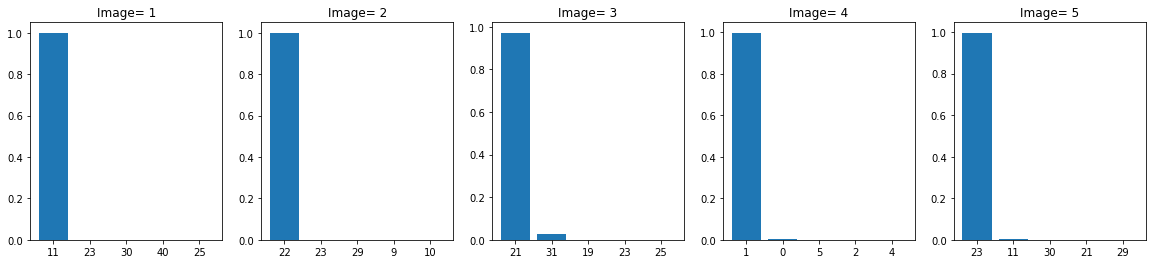

In [597]:
for i in range(5):
    plt.subplot(151 + i)
    plt.bar(range(5),Top5[0][i])
    plt.xticks( range(5), Top5[1][i])
    plt.title('Image= '+str(i+1))
plt.gcf().set_size_inches(20, 4)
plt.show

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [623]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={X : image_input, is_training: 0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    plt.subplot(6,8, 1)
    plt.imshow(X_web_pre[plt_num])
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+2)# sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from /home/gexd7127/git/Udacity/CarND-Traffic-Sign-Classifier-Project/tmp/LeNet_v3_4


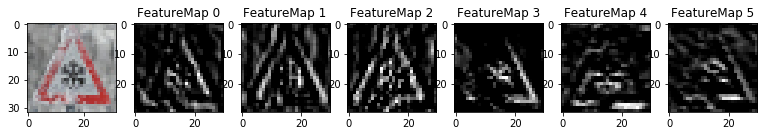

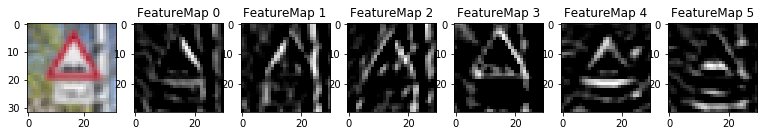

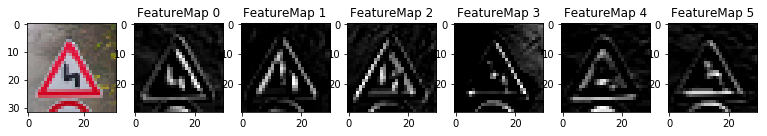

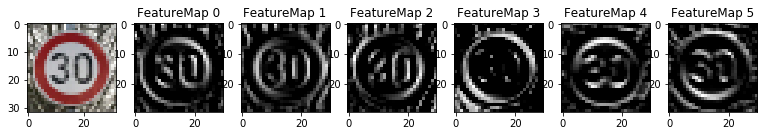

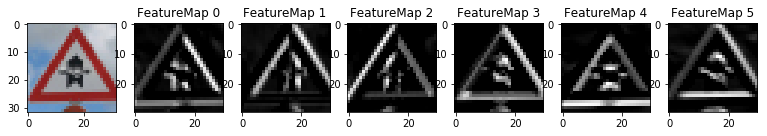

In [628]:
with tf.Session() as sess:
    saver.restore(sess, current_dir+'/tmp/'+save_name)
    for i in range(5):
        outputFeatureMap(X_web[i].reshape([1,32,32,1]), fmap[1], activation_min=-1, activation_max=-1 ,plt_num=i)

INFO:tensorflow:Restoring parameters from /home/gexd7127/git/Udacity/CarND-Traffic-Sign-Classifier-Project/tmp/LeNet_v3_4


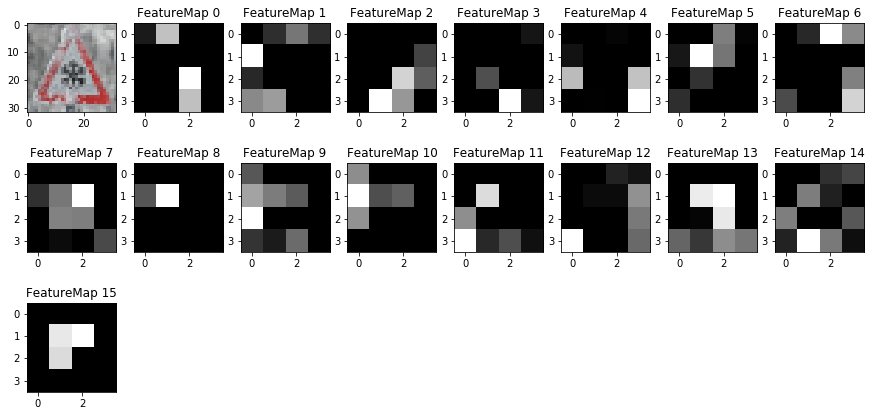

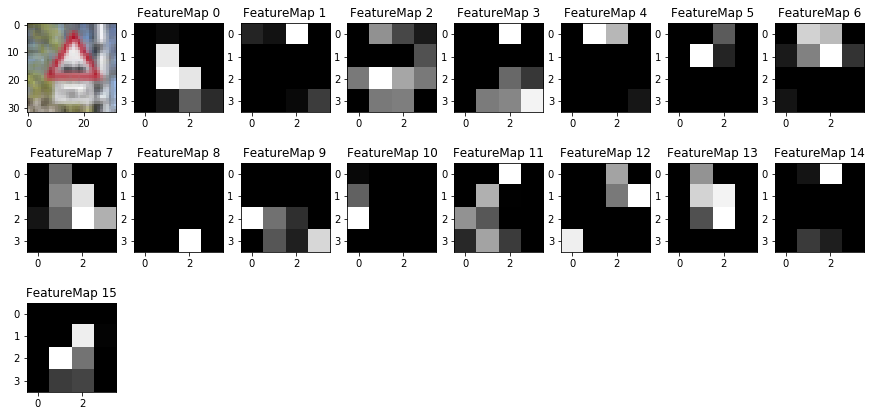

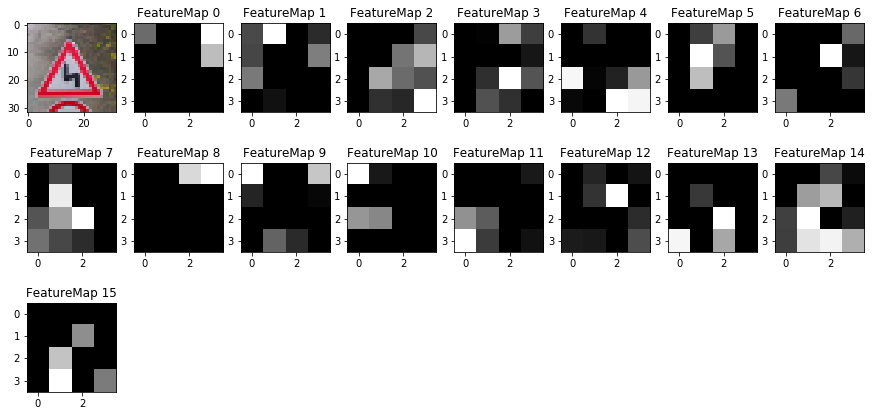

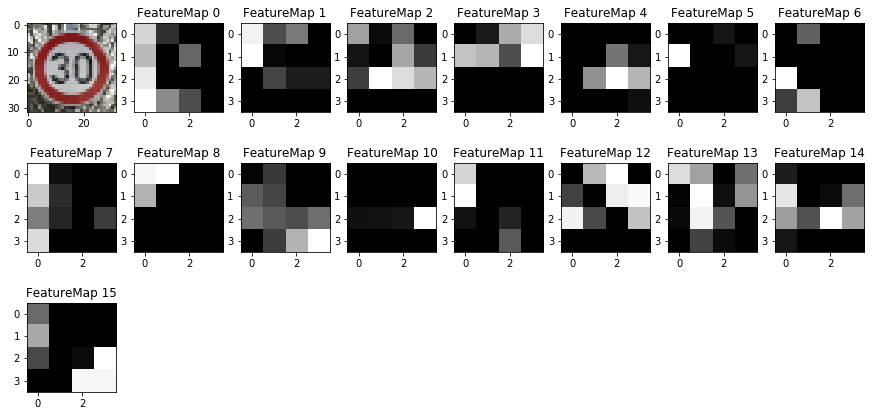

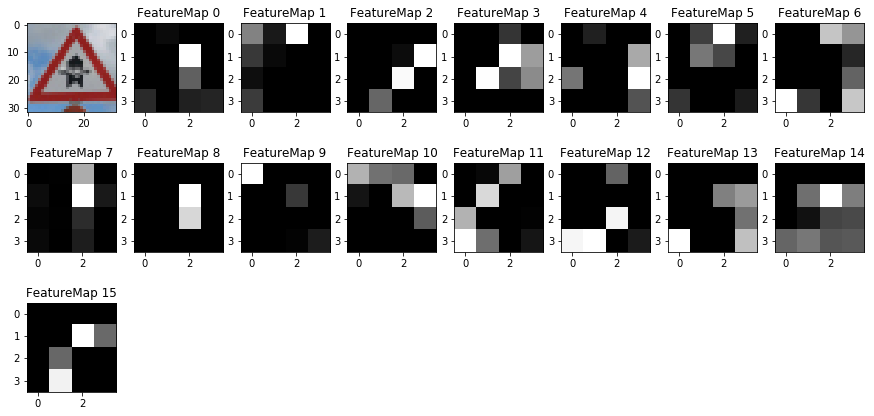

In [631]:
with tf.Session() as sess:
    saver.restore(sess, current_dir+'/tmp/'+save_name)
    for i in range(5):
        outputFeatureMap(X_web[i].reshape([1,32,32,1]), fmap[4], activation_min=-1, activation_max=-1 ,plt_num=i)

In [633]:
fmap

(<tf.Tensor 'MaxPool:0' shape=(?, 15, 15, 6) dtype=float32>,
 <tf.Tensor 'Relu:0' shape=(?, 30, 30, 6) dtype=float32>,
 <tf.Tensor 'MaxPool_1:0' shape=(?, 6, 6, 10) dtype=float32>,
 <tf.Tensor 'Relu_1:0' shape=(?, 13, 13, 10) dtype=float32>,
 <tf.Tensor 'Relu_2:0' shape=(?, 4, 4, 16) dtype=float32>)